In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# model
from xgboost import XGBRegressor

# Set plot styles
plt.style.use('default')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('PJME_hourly.csv')


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [107]:
data.describe(include='all')

,Datetime,PJME_MW
count,145366,145366.000000
unique,145362,NaN
top,2017-11-05 02:00:00,NaN
freq,2,NaN
mean,NaN,32080.222831
std,NaN,6464.012166
min,NaN,14544.000000
25%,NaN,27573.000000
50%,NaN,31421.000000
75%,NaN,35650.000000


In [108]:
print(f'Data Duplicated: {data.duplicated().sum()}')
print(f'Missing: {data.isna().sum()}')

Data Duplicated: 0
Missing: Datetime    0
PJME_MW     0
dtype: int64


In [109]:
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [110]:
data.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [ ]:
# Preprocess Datetime
data = data.set_index(pd.to_datetime(data.Datetime))
data = data.sort_index()
data.drop(columns='Datetime', inplace=True)

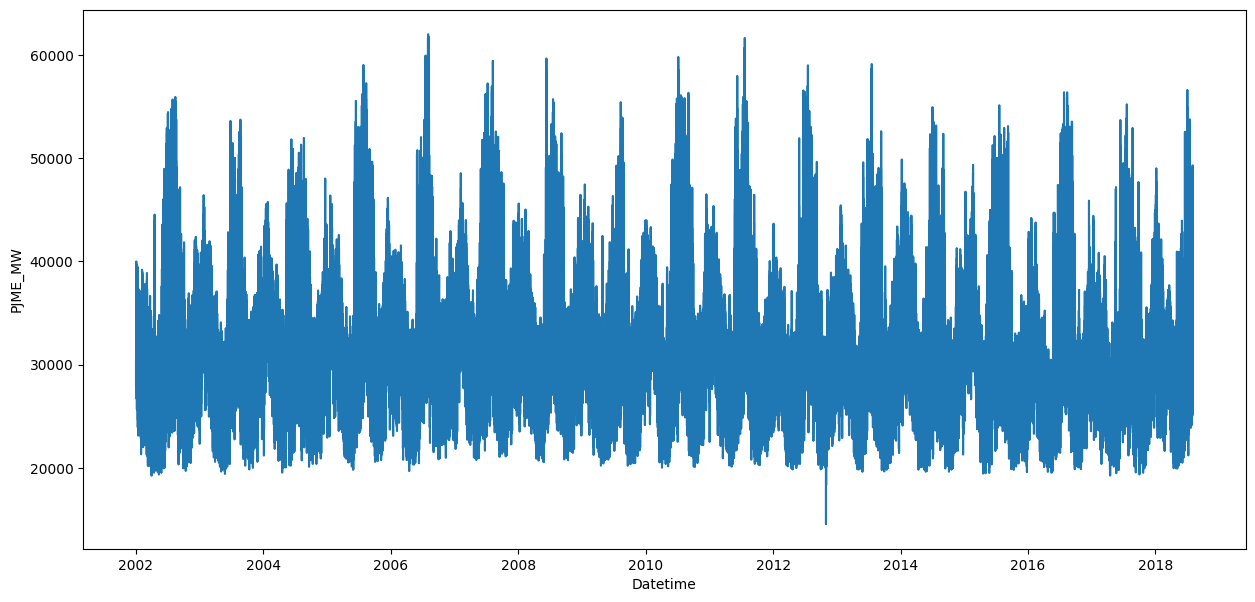

In [ ]:
# Visualize the time series data
plt.figure(figsize=(15,7))
sns.lineplot(y= data.PJME_MW, x=data.index)
plt.show()

<Axes: xlabel='Datetime'>

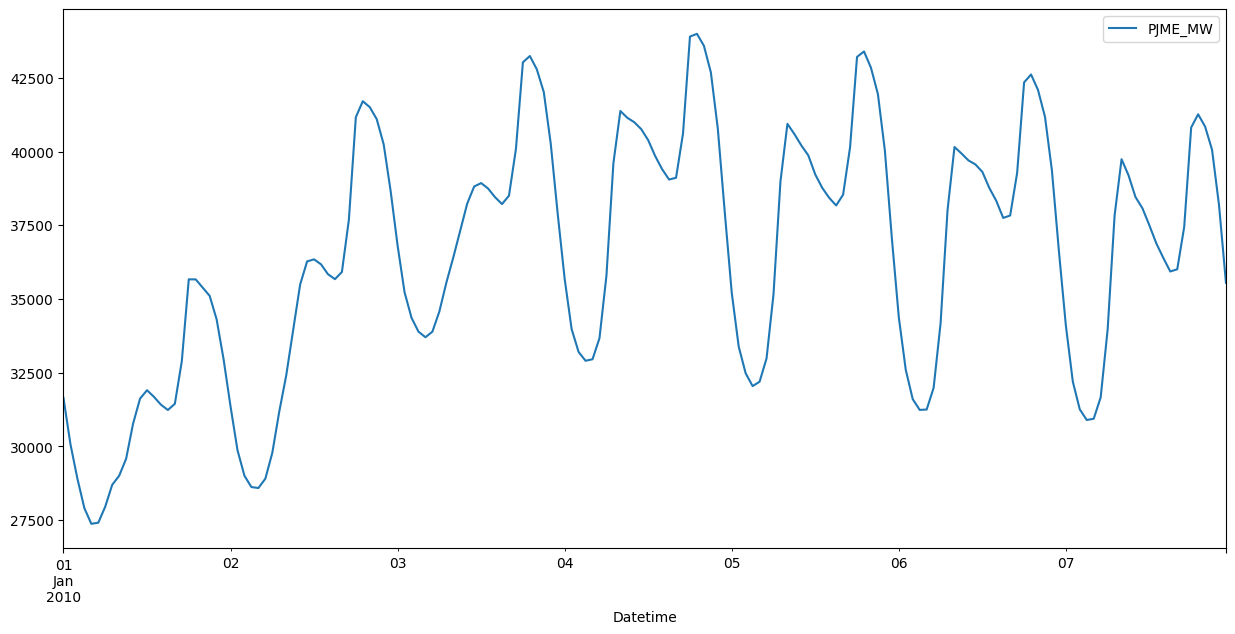

In [ ]:
# plot a week of data
data.loc['2010-01-01':'2010-01-07'].plot(figsize=(15, 7))

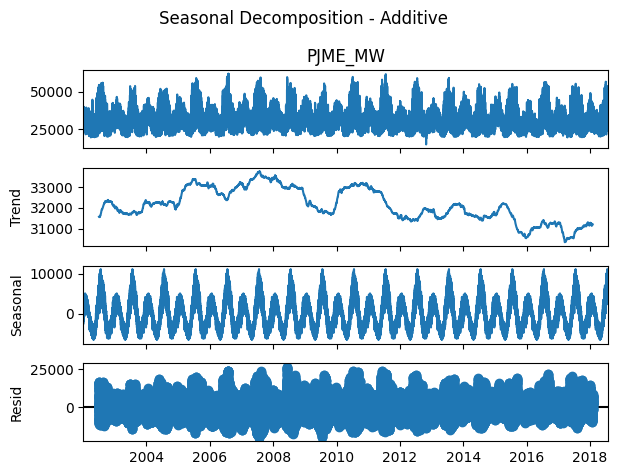

In [ ]:
# Seasonal Decomposition
decomp = seasonal_decompose(data['PJME_MW'], model='additive', period=24*365)

decomp.plot()
plt.suptitle('Seasonal Decomposition - Additive')
plt.tight_layout()
plt.show()

In [ ]:
# Train-Test Split
X_train = data.loc[data.index < '2015-01-01']
X_test =  data.loc[data.index >= '2015-01-01']

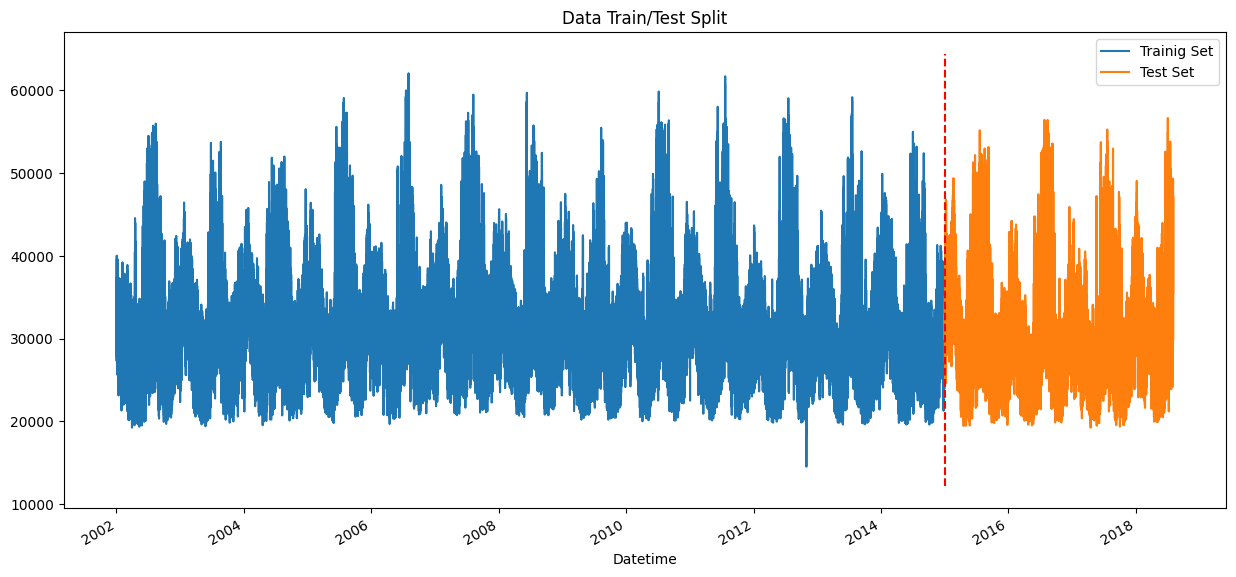

In [ ]:
# Visualize Train-Test Split
fig, ax = plt.subplots(figsize=(15,7))
X_train.plot(ax=ax,label='Training Set',  title='Data Train/Test Split')
X_test.plot(ax=ax, label='Test Set')

y_min, y_max = ax.get_ylim()

ax.vlines(x='2015-01-01', color ='red', ls='--', ymin=y_min,ymax=y_max)
ax.legend(['Trainig Set','Test Set'])
plt.show()

In [ ]:
# Time Series Cross-Validation
tss= TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
data = data.sort_index()

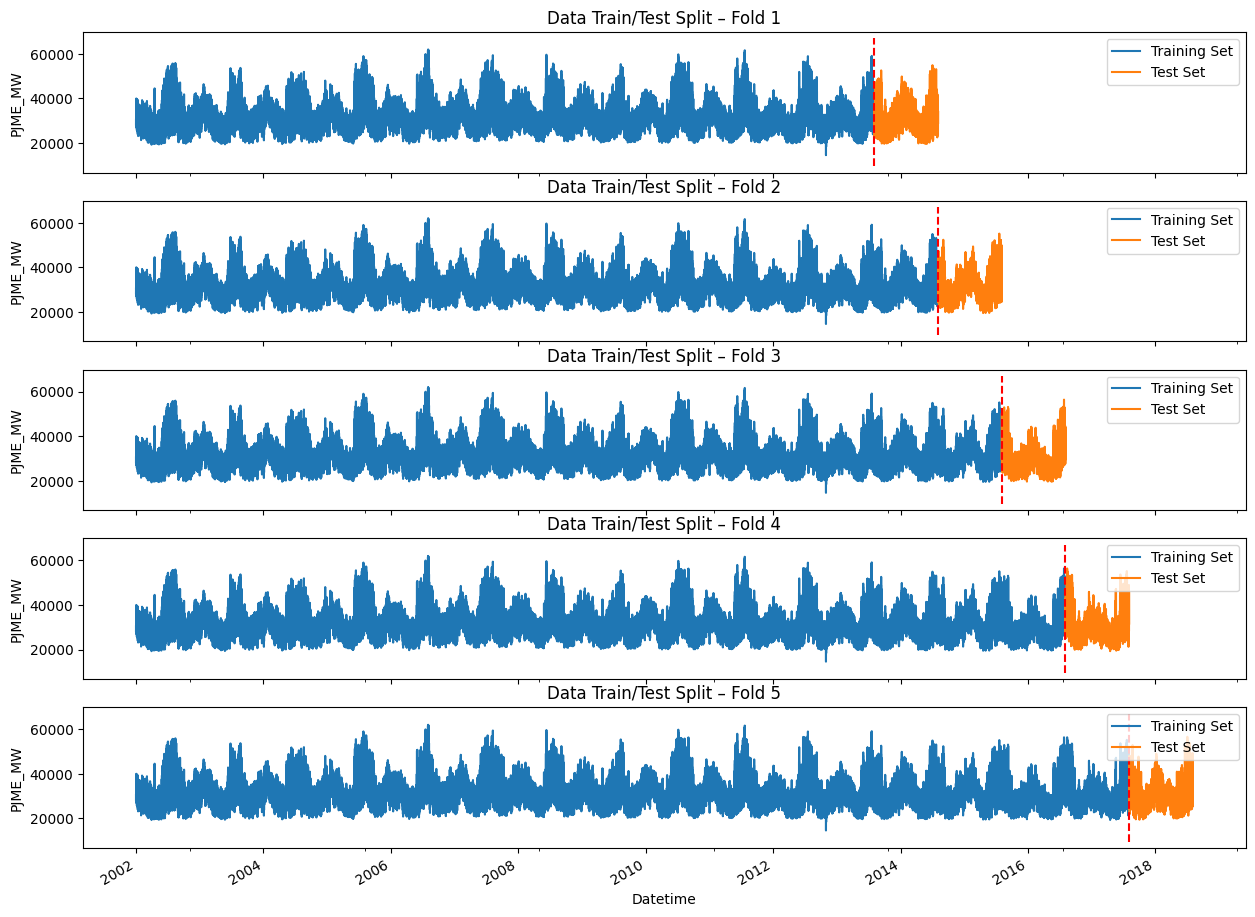

In [ ]:
# Visualize Time Series Cross-Validation Splits
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)


# TimeSeriesSplit preserves temporal order (no leakage)
for fold,  (train_idx, test_idx) in enumerate(tss.split(data)):
    train = data.iloc[train_idx]
    test = data.iloc[test_idx]
    train.PJME_MW.plot(ax=axs[fold], title=f'Data Train/Test Split{fold}', label='Training Set')
    test.PJME_MW.plot(ax=axs[fold], label='Test Set')
    y_min, y_max = ax.get_ylim()

    axs[fold].vlines(test.index.min(), color ='red', ls='--', ymin=y_min,ymax=y_max)

    axs[fold].set_title(f'Data Train/Test Split – Fold {fold+1}')
    axs[fold].set_ylabel('PJME_MW')
    axs[fold].legend(loc='upper right')
plt.show()

In [ ]:
# Feature Engineering
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(data)

In [120]:
df.sample(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2006-08-29 20:00:00,43367.0,20,1,3,8,2006,241,29,35
2018-02-24 20:00:00,29990.0,20,5,1,2,2018,55,24,8
2011-06-17 03:00:00,24922.0,3,4,2,6,2011,168,17,24
2012-12-25 13:00:00,29238.0,13,1,4,12,2012,360,25,52
2012-02-09 00:00:00,30602.0,0,3,1,2,2012,40,9,6


In [ ]:
# Create lag features
def add_lag (df):
    df = df.copy()
    target_map = df['PJME_MW'].to_dict()
    df['lag_7d'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_28d'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_1y'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2y'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3y'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df
df = add_lag(df)

In [122]:
df.tail(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_7d,lag_28d,lag_1y,lag_2y,lag_3y
Datetime,,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,46337.0,50066.0,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,44542.0,48431.0,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,42638.0,46736.0,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,39276.0,43432.0,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,35742.0,40087.0,33539.0,32094.0,31695.0


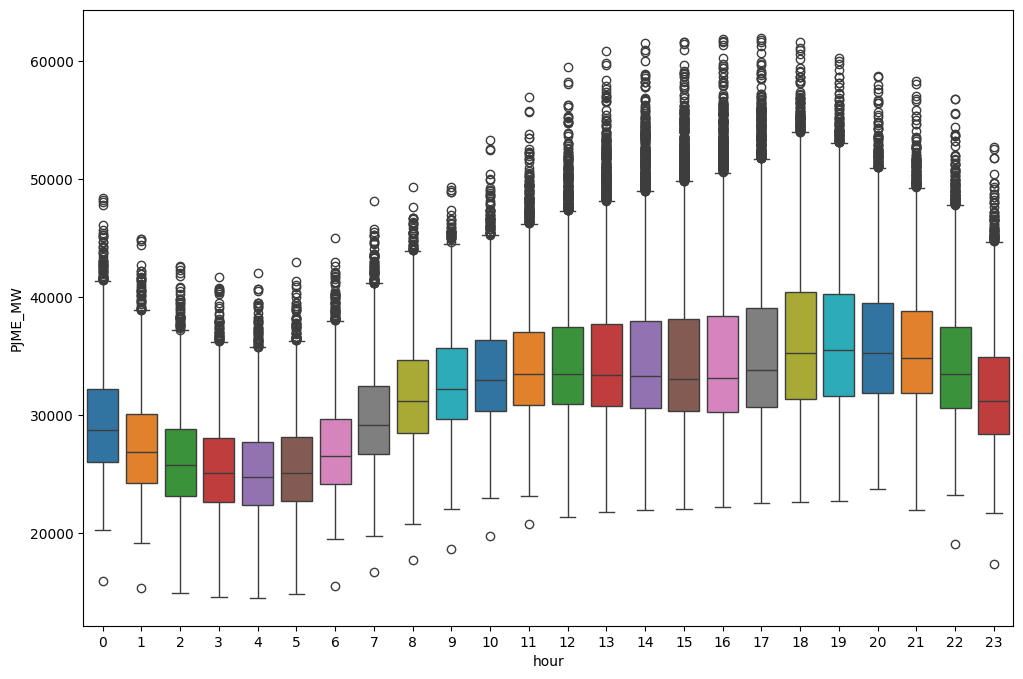

In [ ]:
# Visualize the distribution of target variable by hour of the day
plt.figure(figsize=(12,8))
sns.boxplot(df, x='hour', y='PJME_MW', palette='tab10')
plt.show()

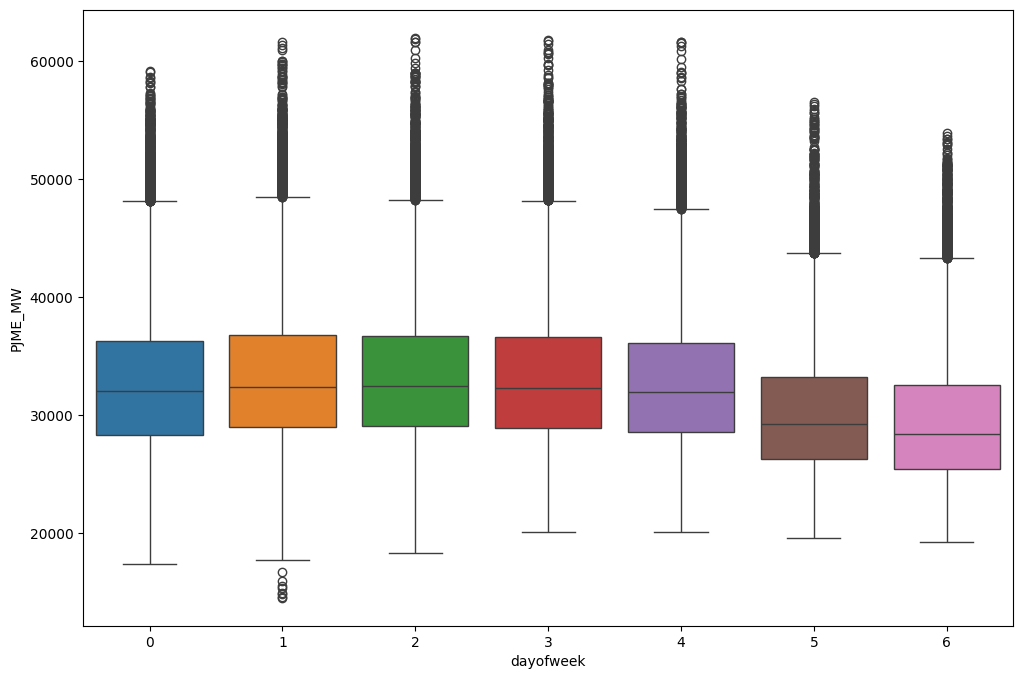

In [ ]:
# Visualize the distribution of target variable by day of the week
plt.figure(figsize=(12,8))
sns.boxplot(df, x='dayofweek', y='PJME_MW', palette='tab10')
plt.show()

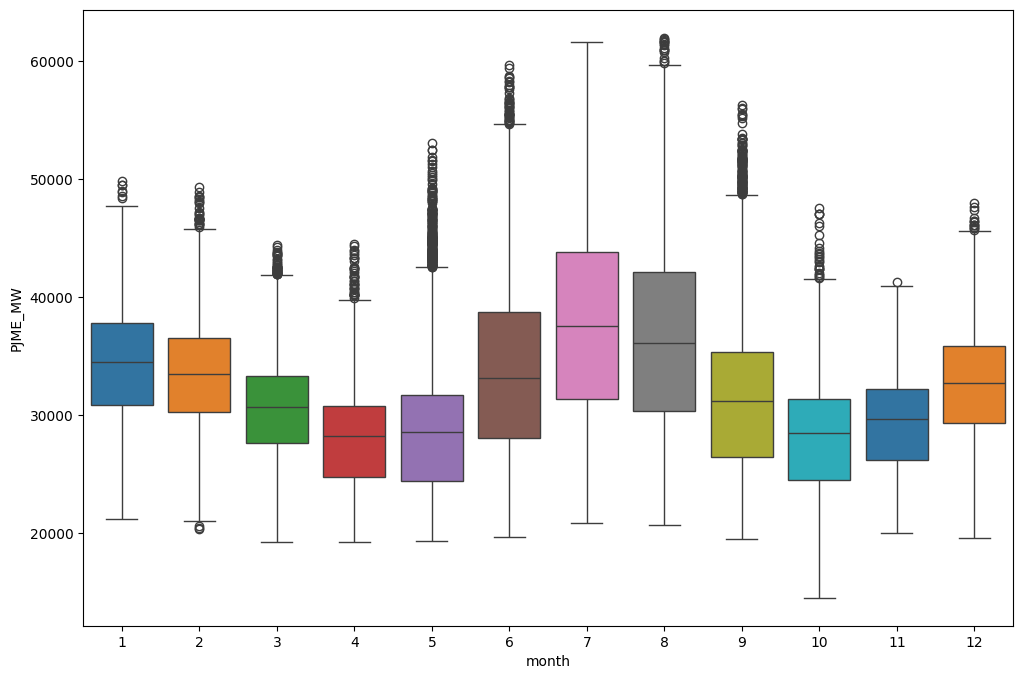

In [ ]:
# Visualize the distribution of target variable by month
plt.figure(figsize=(12,8))
sns.boxplot(df, x='month', y='PJME_MW', palette='tab10')
plt.show()

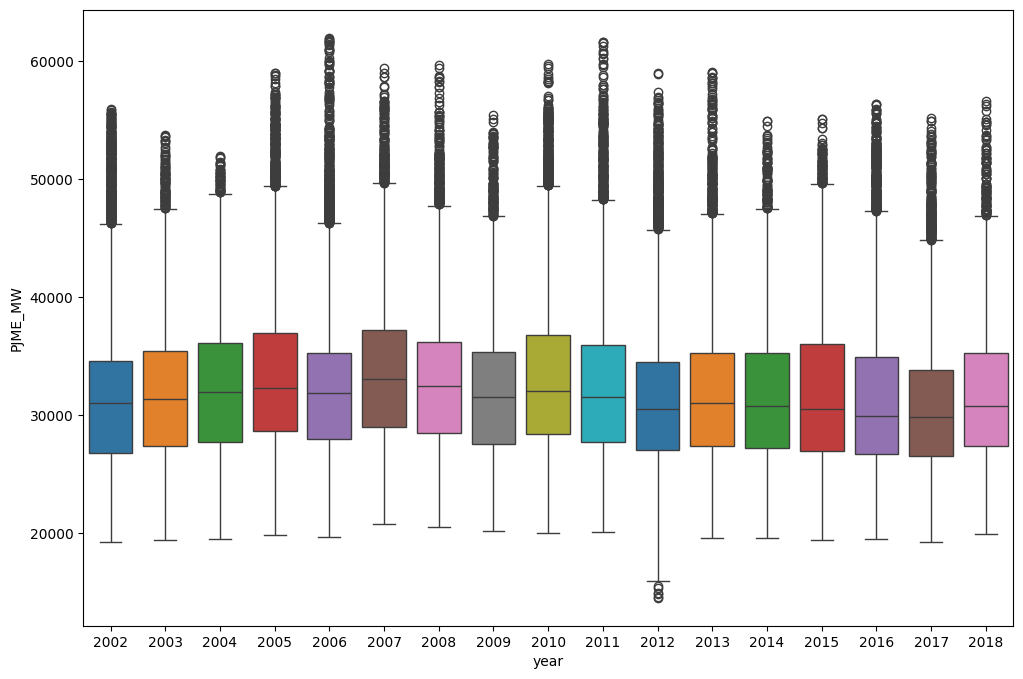

In [ ]:
# Visualize the distribution of target variable by year
plt.figure(figsize=(12,8))
sns.boxplot(df, x='year', y='PJME_MW', palette='tab10')
plt.show()

In [ ]:
# Model Training and Evaluation
cols=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'lag_7d', 'lag_28d', 'lag_1y', 'lag_2y','lag_3y']
scores = []
preds = []
# TimeSeriesSplit preserves temporal order (no leakage)
for train_idx, test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    X_train = train[cols]
    y_train = train['PJME_MW']
    
    X_test = test[cols]
    y_test = test['PJME_MW']

# XGBoost regressor tuned for tabular time-series features
    model = XGBRegressor(n_estimators=1000,
                           early_stopping_rounds=50,
                           max_depth=3,
                           learning_rate=0.01)

# Train with a validation set for early stopping
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6455.75591	validation_1-rmse:6141.95846
[100]	validation_0-rmse:4132.64535	validation_1-rmse:4009.94773
[200]	validation_0-rmse:3497.09989	validation_1-rmse:3599.08508
[300]	validation_0-rmse:3292.62224	validation_1-rmse:3562.31833
[349]	validation_0-rmse:3245.35202	validation_1-rmse:3566.67910
[0]	validation_0-rmse:6431.23211	validation_1-rmse:6249.48627
[100]	validation_0-rmse:4134.34578	validation_1-rmse:4102.02340
[200]	validation_0-rmse:3515.11692	validation_1-rmse:3586.47010
[300]	validation_0-rmse:3321.52482	validation_1-rmse:3464.22495
[400]	validation_0-rmse:3239.96593	validation_1-rmse:3420.32033
[500]	validation_0-rmse:3186.98745	validation_1-rmse:3396.33956
[600]	validation_0-rmse:3151.35453	validation_1-rmse:3383.82074
[700]	validation_0-rmse:3125.41923	validation_1-rmse:3376.64128
[800]	validation_0-rmse:3102.19399	validation_1-rmse:3367.24912
[900]	validation_0-rmse:3082.11140	validation_1-rmse:3365.73250
[901]	validation_0-rmse:3081.85072	validatio

In [ ]:
# Output the results
print(f'Score across folds {np.mean(scores):0.2f}')
print(f'Fold scores:{scores}')

Score across folds 3558.49
Fold scores:[np.float64(3562.3183316573404), np.float64(3364.2898835822502), np.float64(3259.5094254386454), np.float64(3860.3266393080517), np.float64(3745.981500193734)]


In [ ]:
# Final Model Training on All Data
X_all = df.drop(columns='PJME_MW')
y_all = df.PJME_MW

# XGBoost regressor tuned for tabular time-series features
final_model = XGBRegressor(base_score=0.5,
                   booster='gbtree',    
                   n_estimators=1000,
                   objective='reg:linear',
                   max_depth=3,
                   learning_rate=0.01)

# Train with a validation set for early stopping
final_model.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:32402.07379
[100]	validation_0-rmse:12352.64008
[200]	validation_0-rmse:5555.88739
[300]	validation_0-rmse:3730.63048
[400]	validation_0-rmse:3365.56361
[500]	validation_0-rmse:3277.14068
[600]	validation_0-rmse:3241.34546
[700]	validation_0-rmse:3216.72869
[800]	validation_0-rmse:3196.84832
[900]	validation_0-rmse:3177.98591
[999]	validation_0-rmse:3161.62079


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [130]:
#Last Record:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
#Create Feature:
future = pd.date_range('2018-08-04','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lag(df_and_future)

#Separating future values
future_w_features = df_and_future.query('isFuture').copy()

In [132]:
test_data = future_w_features.drop(columns=['PJME_MW','isFuture'])
# Predict future values using the trained model
future_w_features['pred'] = final_model.predict(test_data)

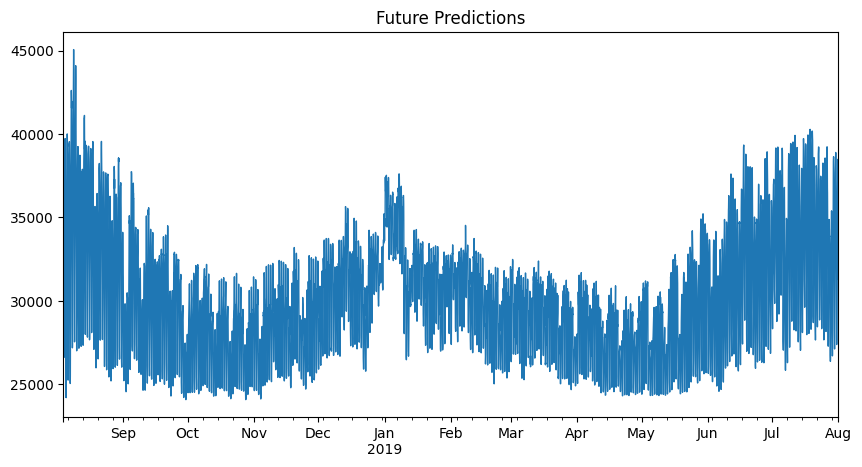

In [133]:
# Predict future values using the trained model
future_w_features['pred'].plot(figsize=(10, 5), ms=1, lw=1, title='Future Predictions')
plt.show()

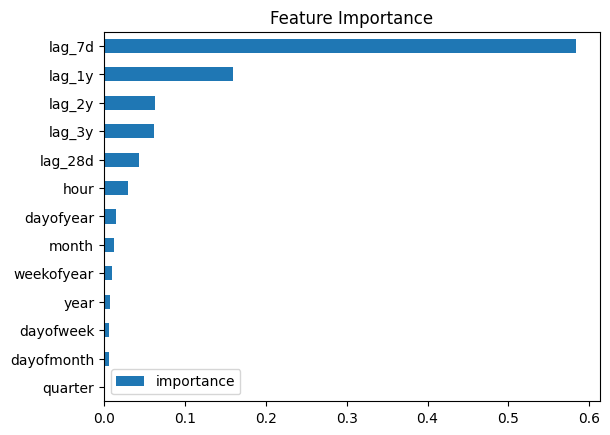

In [ ]:
# Feature Importance Visualization
fi = pd.DataFrame(data=final_model.feature_importances_,
             index=final_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# Output the best and worst fold scores
print(f'Best RMSE across folds: {min(scores):.2f} MW')
print(f'Worst RMSE across folds: {max(scores):.2f} MW')

Best RMSE across folds: 3259.51 MW
Worst RMSE across folds: 3860.33 MW


In [ ]:
# Save the final model
final_model.save_model("energy_model.json")